# Distributed Turbulence Data FileDB Node Assignment

This notebook generates the node assignment for the $512^3$ sub-cubes for the
$8192^3$ turbulence data. The data is distributed such that given a location $(i, j, k)$ stored 
on FileDB node $n$, representing a single $512^3$ sub-cube, all sub-cubes that are next to that 
cube in any direction (i.e. $(i`, j`, k`)$, $i`\in [i-1, i+1], i` \neq i$, 
$j`\in [j-1, j+1], j` \neq j$,  $k`\in [k-1, k+1], k` \neq k$) are not assigned to $n$ and can 
therefore be accessed in parallel.



<font color="orange">Ariel's edit 30-Jun-23 of Ryan's notebook</font>

In [1]:
from itertools import product

import numpy as np

In [2]:
# There are 34 availble nodes that are 1-indexed
colors = np.arange(34) + 1
# An array for holding how often a node has been assigned too.
color_counts = np.zeros_like(colors)
# An array to store the node assignment the 8192^3 data is broken into 512^3
# sub-cubes so we need to 8192/512=16 assignments along each dimension

cube_side = 4 # Ariel change - it was 16 for 8192 dataset


nodes = np.zeros([cube_side, cube_side, cube_side], dtype=int)

In [3]:
def get_bounds(idx:int, mx:int):
    """Helper for requesting valid indicies around an index"""
    return max(idx-1, 0), min(idx+2, mx)

In [4]:
# iterate through the position indicies in `nodes` and assign available 
# nodes greedily such that there is not a matching node within the 
# (8 + 9 + 9) 26 cube neighborhood.
for i, j, k in product(np.arange(cube_side), np.arange(cube_side), np.arange(cube_side)):
    if nodes[i, j, k] == 0:
        neighbor_colors = nodes[
            slice(*get_bounds(i, cube_side)),
            slice(*get_bounds(j, cube_side)),
            slice(*get_bounds(k, cube_side))
        ]
        avail_colors = np.setdiff1d(colors, neighbor_colors.flatten())
        color_idxs = avail_colors-1
        greedy_color_idx = np.argmin(color_counts[color_idxs])
        greedy_color = colors[color_idxs[greedy_color_idx]]
        color_counts[color_idxs[greedy_color_idx]] += 1
        
        nodes[i, j, k] = greedy_color


In [5]:
np.save("node_assignment.npy", nodes)

In [6]:
def validate_colors(arr:np.ndarray) -> bool:
    """Helper function to validate that the node assignment doesn't contain any conflicts."""

    for i, j, k in product(*list(map(range, arr.shape))):
        element_color = arr[i, j, k]
        for ni, nj, nk in filter(
            lambda ijk: ijk != (i, j, k),
            product(
                range(*get_bounds(i, cube_root)),
                range(*get_bounds(j, cube_root)),
                range(*get_bounds(k, cube_root)),
        )):
            if element_color == arr[ni, nj, nk]:
                print(i, j, k, "equals", ni, nj, nk)
                return False
        
    return True

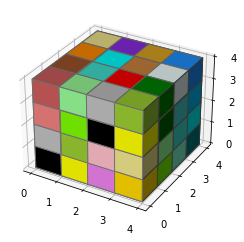

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
 
# Create axis
axes = [cube_side, cube_side, cube_side]
 
# Create Data
data = np.ones(axes, dtype=bool)
 
# Control Transparency
alpha = 0.9
 
named_colors = [
    "black",
    "silver",
    "lightcoral",
    "indianred",
    "brown",
    "red",
    "orangered",
    "sienna",
    "chocolate",
    "peru",
    
    "bisque",
    "darkorange",
    "orange",
    "goldenrod",
    "gold",
    "khaki",
    "yellow",
    "yellowgreen",
    "lawngreen",
    "palegreen",
    
    "darkgreen",
    "green",
    "aquamarine",
    "turquoise",
    "mediumturquoise",
    "azure",
    "teal",
    "cyan",
    "deepskyblue",
    "dodgerblue",
    
    "blue",
    "blueviolet",
    "violet",
    "pink"
]
    
facecolors = np.empty(axes, dtype=object)

for i, j, k in product(np.arange(cube_side), np.arange(cube_side), np.arange(cube_side)):
    facecolors[i, j, k] = named_colors[nodes[i, j, k]-1]
    
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.voxels(data, facecolors=facecolors, edgecolors='grey')


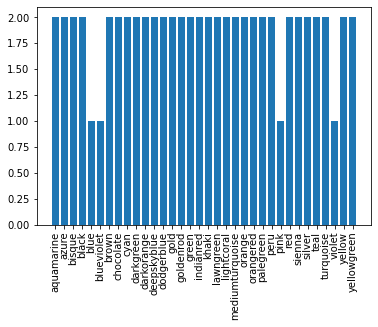

In [8]:
f, ax = plt.subplots()
color_names, counts = np.unique(facecolors, return_counts=True)
ax.bar(color_names, counts)
_ = plt.xticks(rotation='vertical')

In [9]:
nodes

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]],

       [[17, 18, 19, 20],
        [21, 22, 23, 24],
        [25, 26, 27, 28],
        [29, 30, 31, 32]],

       [[33, 34,  1,  2],
        [ 3,  4,  5,  6],
        [ 7,  8,  9, 10],
        [11, 12, 13, 14]],

       [[15, 16, 17, 18],
        [19, 20, 21, 22],
        [23, 24, 25, 26],
        [27, 28, 29, 30]]])